# Rating movies data cleaning

<hr>

In [31]:
# Import the necessary libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz
from collections import defaultdict, Counter
from joblib import Parallel, delayed
from unidecode import unidecode

In [32]:
def validate_change_date(df, columns, fill_date, amount_null):
    """
    Validate the data filled with the date 1900-01-01 is the same that null data
    """ 
    count = (df[columns] == fill_date).sum().sum()
    if count == amount_null:
        return "OK"
    else:
        return f"Fill data error: {count} != {amount_null}"

In [33]:
def transform_to_string(df, value):
    """
    Transform type of data in a column to string.
    This function assumes that each cell in the specified columns contains an iterable (e.g., a list).
    It sorts the elements in each iterable and joins them into a single string, separated by commas.
    """
    for obj in value:
        df[obj] = df[obj].apply(lambda x: ', '.join(sorted(x)))

In [34]:
def normalize_category_fuzzy(value, choices, threshold=80):
    """ 
    Normalizes a given string value by finding the closest match in a list of choices 
    using fuzzy matching with rapidfuzz.
    """
    if isinstance(value, str):
        best_match = process.extractOne(value, choices)  # get the best match and its score
        if best_match and best_match[1] >= threshold:    # Ensure the score is sufficient
            return best_match[0]                         # Return the name of the best match
    return 'nr' 

In [35]:
def fill_date_null(df, dates, date_fict):
    """
    Fill null dates in specified columns of a DataFrame with a fictitious date
    """ 
    for col in dates:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        df[col] = df[col].fillna(pd.Timestamp(date_fict))
    return df[col]

In [36]:
# Compile the regular expression to delete irrelevants terms
irrelevant_terms = re.compile(r'\b(inc|corp|corporation|limited|ltd|plc|pictures|picture|co|entertainment|films|film|studios|corporat)\b')

def preprocess_company(company):
    """ 
    Preprocesses a company name by applying several cleaning steps.
    
    The function converts the company name to lowercase, removes irrelevant terms, 
    strips special characters, and normalizes spaces.
    """
    company = company.lower().strip()               # Convert the company name to lowercase and remove spaces
    company = irrelevant_terms.sub('', company)     # Remove irrelevant terms that do not affect the main name
    company = re.sub(r'[^\w\s]', '', company)       # Remove special characters from the company name
    company = re.sub(r'\s+', ' ', company).strip()  # Replace multiple spaces with a single space and strip spaces
    return company

In [37]:
def group_similar(company, all_companies, threshold=85):
    """
    Finding the best matches from a list of company names using fuzzy matching.
    """
    # Find matches with process.extract from RapidFuzz
    matches = process.extract(company, all_companies, scorer=fuzz.token_sort_ratio, score_cutoff=threshold)
    
    if matches:
        try:
            # Extract the matched company names from the tuples
            match_names = [match[0] for match in matches]  
            most_common = Counter(match_names).most_common(1)
            return most_common[0][0] if most_common else company   # Return the most common match
        except IndexError:
            return "ERROR"
    return company  # Return the original company name if no matches are found

In [38]:
# Función para procesar compañías en paralelo
def process_company(companies, threshold=85):
    """
    Processes a list of company names in parallel to group similar companies, applying the group_similar function
    """
    return Parallel(n_jobs=-1)(
        delayed(group_similar)(company, companies, threshold) for company in companies
    )

## Read dataset

In [39]:
original_data = pd.read_csv('rotten_tomatoes_movies.csv')
raw_data = original_data.copy()

## Exploratory Data Analysis (EDA)

In [40]:
raw_data.head(100)

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Foxting,Roten,49.0,149.0,Spill,NaN,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified Fresh,87.0,142.0,Upight,64.0,11574.0,44,123,19
2,m/10,NaN,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fesh,67.0,24.0,Spiled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,m/10008507-deep_water,Deep Water,"In 1968, Donald Crowhurst, an inexperienced Br...","Equal parts mystery and biography, Deep Water ...",PG,"Documentary, Special Interest","Louise Osmond, Jerry Rothwell","Louise Osmond, Jerry Rothwell","Tilda Swinton, Donald Crowhurst, Santiago Fran...",2006-09-03,...,IFC Films,Certified-Fresh,96.0,55.0,Upright,87.0,4961.0,22,53,2
96,m/10008562-road_to_victory,Road to Victory,A young football player (Mike Reilly) faces mo...,NaN,NR,"Art House & International, Drama, Sports & Fit...",Mike Reilly,Mike Reilly,"Mike Reilly, Julia Anderson, Winston Brown, Pe...",2007-03-18,...,Vanguard,Fresh,78.0,9.0,Upright,78.0,89.0,0,7,2
97,m/10008587-beverly_hills_chihuahua,Beverly Hills Chihuahua,"Chloe (Drew Barrymore), a pampered Chihuahua f...","Despite hitting some sweet notes, Beverly Hill...",PG,Comedy,Raja Gosnell,"Analisa LaBianco, Jeffrey Bushell","Drew Barrymore, Andy Garcia, Jamie Lee Curtis,...",2008-09-30,...,Walt Disney Pictures,Rotten,40.0,99.0,Spilled,52.0,186570.0,29,40,59
98,m/10008601-fireflies_in_the_garden,Fireflies in the Garden,Successful novelist Michael (Ryan Reynolds) vi...,"Despite boasting a stellar cast, Fireflies in ...",R,Drama,Dennis Lee (III),Dennis Lee (III),"Emily Watson, Julia Roberts, Ryan Reynolds, Wi...",2011-10-14,...,Senator Entertainment,Rotten,22.0,54.0,Spilled,45.0,45155.0,23,12,42


In [41]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18173 entries, 0 to 18172
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              18173 non-null  object 
 1   movie_title                       18167 non-null  object 
 2   movie_info                        17847 non-null  object 
 3   critics_consensus                 9380 non-null   object 
 4   content_rating                    18173 non-null  object 
 5   genres                            18154 non-null  object 
 6   directors                         17976 non-null  object 
 7   authors                           16605 non-null  object 
 8   actors                            17818 non-null  object 
 9   original_release_date             16994 non-null  object 
 10  streaming_release_date            17782 non-null  object 
 11  runtime                           17853 non-null  float64
 12  prod

In [42]:
raw_data.isnull().sum()

rotten_tomatoes_link                   0
movie_title                            6
movie_info                           326
critics_consensus                   8793
content_rating                         0
genres                                19
directors                            197
authors                             1568
actors                               355
original_release_date               1179
streaming_release_date               391
runtime                              320
production_company                   505
tomatometer_status                    44
tomatometer_rating                    44
tomatometer_count                     44
audience_status                      452
audience_rating                      302
audience_count                       301
tomatometer_top_critics_count          0
tomatometer_fresh_critics_count        0
tomatometer_rotten_critics_count       0
dtype: int64

In [43]:
raw_data.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17853.000000,18129.000000,18129.000000,17871.000000,1.787200e+04,18173.000000,18173.000000,18173.000000
mean,102.233294,60.877710,56.798003,60.540093,1.416713e+05,14.517691,36.096572,20.642547
std,18.753662,28.443257,67.962033,20.524558,1.741135e+06,15.109396,52.192479,30.194011
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,7.200000e+02,3.000000,6.000000,3.000000
50%,99.000000,67.000000,28.000000,63.000000,4.354500e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,75.000000,78.000000,2.523875e+04,23.000000,43.000000,23.000000
max,266.000000,100.000000,574.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000


## Data cleaning

### Definition of data types and categories

In [44]:
# lists according to data type
categorical = ['content_rating','tomatometer_status','audience_status']
irrelevant  = ['rotten_tomatoes_link', 'movie_info', 'critics_consensus','tomatometer_count', 
                'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 
                'tomatometer_rotten_critics_count','audience_count']
relevant    = ['movie_title']
objs        = ['directors', 'genres', 'authors', 'actors', 'production_company']
numeric     = ['runtime']
ratings     = ['tomatometer_rating', 'audience_rating']
dates       = ['original_release_date', 'streaming_release_date']

In [45]:
# definition of categories
rating   = ['g', 'nc17', 'nr', 'pg', 'pg13', 'r']
t_status = ['rotten', 'fresh', 'certified-fresh', 'nr']
a_status = ['spilled', 'upright', 'nr']

### Remove

In [46]:
# remove irrelevant columns
raw_data = raw_data.drop(columns= irrelevant, errors='ignore')

In [47]:
# remove rows with missing values in relevant columns
raw_data = raw_data.dropna(subset=relevant)

In [48]:
# remove duplicates
raw_data = raw_data.drop_duplicates(subset=['movie_title','original_release_date','directors'])

### Null values

In [49]:
# fill missing category values
for col in categorical:
    raw_data[col] = raw_data[col].str.lower().fillna('nr').astype('category')

In [50]:
# fill missing objects values
raw_data[objs] = raw_data[objs].fillna('nr')

In [51]:
# fill missing numeric values
raw_data[numeric] = raw_data[numeric].fillna(0.0).astype('float64')

In [52]:
# fill missing dates values with 1900-01-01
amount_null = raw_data[dates].isnull().sum().sum()
fill_date_null(raw_data, dates, '1900-01-01')
validate_change_date(raw_data, dates, '1900-01-01', amount_null)

'OK'

### Normalize object columns

In [53]:
# Convert to lowercase
lower = raw_data.select_dtypes(include=['object']).columns
for col in lower:
    raw_data[col] = raw_data[col].str.lower()


# Normalize objects with frozenset
raw_data[objs] = (
    raw_data[objs]
    .replace('&', ',', regex=True)
    .apply(lambda col: col.str.split(',').apply(lambda x: frozenset(map(str.strip, x))))
)

### Rating fill

In [54]:
# Fill nulls of tomatometer_rating with audience_rating and vice versa
raw_data[ratings] = raw_data[ratings].apply(lambda x: x.fillna(raw_data[ratings].mean(axis=1)))

In [55]:
# Fill nulls in both columns with median
raw_data[ratings] = raw_data.groupby('genres')[ratings].transform(lambda x: x.fillna(x.median()))

In [56]:
# Fill the others nulls with mean
raw_data[ratings] = raw_data[ratings].fillna(raw_data[ratings].mean())

### fuzzy data normalization

In [57]:
# Transfor frozenset to string
transform_to_string(raw_data,objs)

In [58]:
# Normalize categories
category_dict = {
    'content_rating': rating,
    'tomatometer_status': t_status,
    'audience_status': a_status
    }
for col, choices in category_dict.items():
    raw_data[col] = raw_data[col].apply(lambda x: normalize_category_fuzzy(x, choices)).astype('category')

In [59]:
# Normalize companies with rapidfuzz
raw_data['production_company'] = raw_data['production_company'].apply(preprocess_company)
companies_list = raw_data['production_company'].tolist()
raw_data['production_company'] = process_company(companies_list, threshold=85)
clean_data = raw_data

In [60]:
clean_data.head(10)

,movie_title,content_rating,genres,directors,authors,actors,original_release_date,streaming_release_date,runtime,production_company,tomatometer_status,tomatometer_rating,audience_status,audience_rating
0,percy jackson & the olympians: the lightning t...,pg,"action, adventure, comedy, drama, fantasy, sci...",chris columbus,"chris columbus, craig titley, rick riordan","alexandra daddario, alexis knapp, andrea brook...",2010-02-12,2015-11-25,119.0,20th century fox,rotten,49.0,spilled,49.0
1,please give,r,comedy,nicole holofcener,nicole holofcener,"amanda peet, ann morgan guilbert, catherine ke...",2010-04-30,2012-09-04,90.0,sony classics,certified-fresh,87.0,upright,64.0
3,12 angry men (twelve angry men),nr,"classics, drama",sidney lumet,reginald rose,"billy nelson, e.g. marshall, ed begley sr., ed...",1957-04-13,2017-01-13,95.0,criterion collection,certified-fresh,100.0,upright,97.0
4,"20,000 leagues under the sea",g,"action, adventure, drama, family, kids",richard fleischer,earl felton,"bob wilke, carleton young, eddie marr, esmeral...",1954-01-01,2016-06-10,127.0,disney,fresh,89.0,upright,74.0
5,"10,000 b.c.",g,"action, adventure, classics, drama",roland emmerich,"harald kloser, roland emmerich","affif ben badra, boubacar badaine, camilla bel...",2008-03-07,2013-06-22,109.0,warner bros,rotten,8.0,spilled,37.0
7,3:10 to yuma,nr,"classics, drama, western",delmer daves,halsted welles,"barry curtis, felicia farr, ford rainey, georg...",1957-08-07,2012-04-16,92.0,columbia,fresh,96.0,upright,79.0
8,charly (a heartbeat away),pg,"comedy, drama, romance",adam thomas anderegg,"jack weyland, janine whetton gilbert","gary neilson, heather beers, jackie winterrose...",2002-09-27,2017-05-22,103.0,excel,rotten,20.0,upright,87.0
9,abraham lincoln,nr,"classics, drama",d.w. griffith,"gerrit j. lloyd, stephen vincent benét","cameron prud'homme, carl stockdale, charles cr...",1930-11-08,2013-12-03,97.0,united artists,fresh,82.0,spilled,40.0
11,the accused,r,"drama, mystery, suspense",jonathan kaplan,tom topor,"allan lysell, andrew kavadas, ann hearn, antho...",1988-10-14,2016-10-04,110.0,paramount,fresh,91.0,upright,79.0
12,the lost city,r,drama,andy garcia,"g. cabrera infante, guillermo cabrera infante","andy garcia, bill murray, daniel pino, dominik...",2005-09-03,2017-03-23,143.0,magnolia,rotten,25.0,upright,64.0


## Load data

In [61]:
clean_data.to_csv('rotten_tomatoes_movies_clean.csv', index=False)

In [62]:
# Decompose the genre string into a list
df_normalized = clean_data[clean_data['directors'] != 'nr'].copy()

df_normalized['genres_normalized'] = df_normalized['genres'].str.split(',') 

# Normalized genres
df_normalized['genres_normalized'] = df_normalized['genres_normalized'].apply(lambda x: [unidecode(genre.strip()) for genre in x])

# Descompose the directors string into a list

df_normalized['directors_normalized'] = df_normalized['directors'].str.split(',')   

# Normalized directors
df_normalized['directors_normalized'] = df_normalized['directors_normalized'].apply(lambda x: [unidecode(director.strip()) for director in x])

# Explode the list of genres
genres = df_normalized['genres_normalized'].explode().str.strip()  

# Explode the list of directors
directors = df_normalized['directors_normalized'].explode().str.strip().str.title()

# Count the frecuency of each genre
genre_counts = genres.value_counts()

# Count the frecuency of each director
top_directors = directors.value_counts().nlargest(15)

## Visualization

In [63]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17709 entries, 0 to 17711
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   movie_title             17709 non-null  object        
 1   content_rating          17709 non-null  category      
 2   genres                  17709 non-null  object        
 3   directors               17709 non-null  object        
 4   authors                 17709 non-null  object        
 5   actors                  17709 non-null  object        
 6   original_release_date   17709 non-null  datetime64[ns]
 7   streaming_release_date  17709 non-null  datetime64[ns]
 8   runtime                 17709 non-null  float64       
 9   production_company      17709 non-null  object        
 10  tomatometer_status      17709 non-null  category      
 11  tomatometer_rating      17709 non-null  float64       
 12  audience_status         17709 non-null  category   

In [64]:
clean_data.isnull().sum()

movie_title               0
content_rating            0
genres                    0
directors                 0
authors                   0
actors                    0
original_release_date     0
streaming_release_date    0
runtime                   0
production_company        0
tomatometer_status        0
tomatometer_rating        0
audience_status           0
audience_rating           0
dtype: int64

In [65]:
# Filter the top 15 genres
top_genres = genre_counts.nlargest(15)

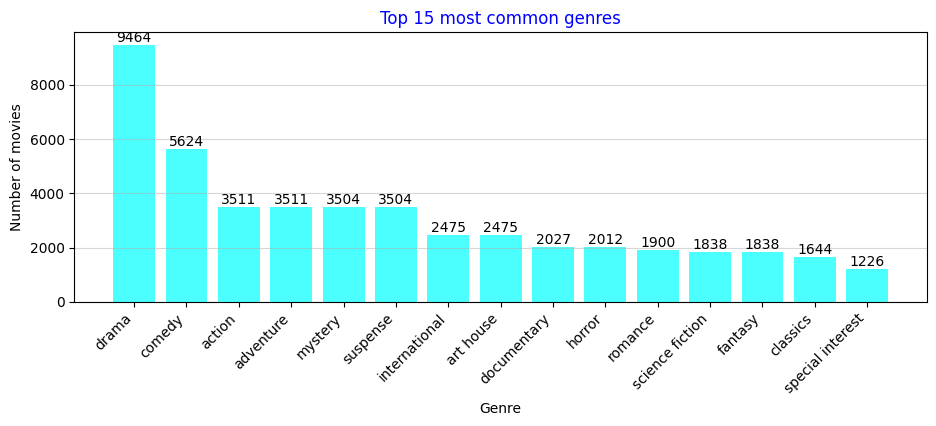

In [66]:
plt.figure(figsize=(11, 3.5))  
bars = plt.bar(top_genres.index, top_genres.values, color='cyan', alpha=0.7)
plt.title('Top 15 most common genres', color='blue')
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.xticks(rotation=45, ha='right', fontsize=10)  
plt.grid(axis='y', alpha=0.5)  
plt.bar_label(bars, label_type='edge') 
plt.show()


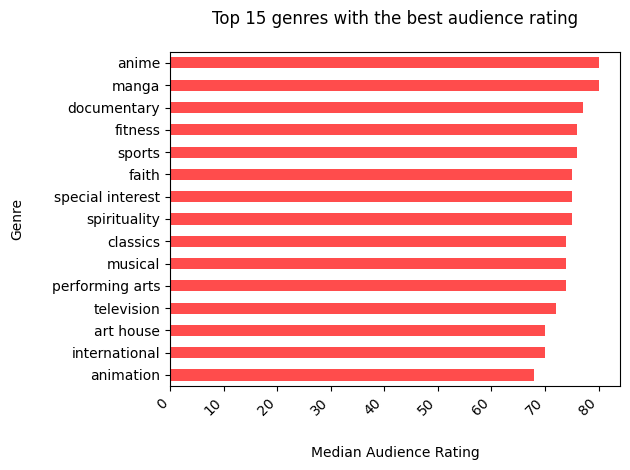

In [67]:
top_15 = df_normalized.explode('genres_normalized').groupby('genres_normalized')['audience_rating'].median().nlargest(15)
top_15.plot(kind='barh', color='red', alpha=0.7)
plt.title('Top 15 genres with the best audience rating', pad=20)
plt.xlabel('Median Audience Rating', labelpad=20)
plt.ylabel('Genre', labelpad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.gca().invert_yaxis() 
plt.show()

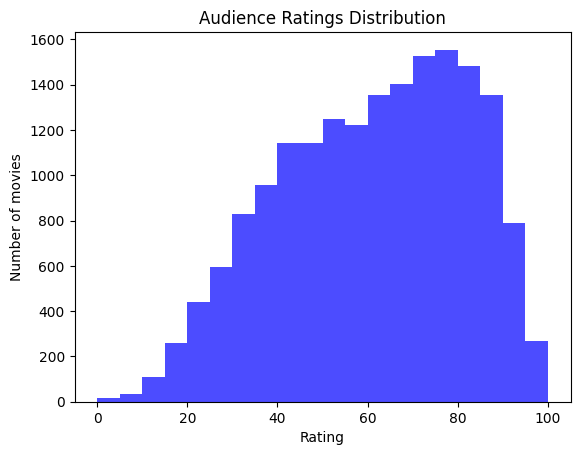

In [68]:
plt.hist(raw_data['audience_rating'].dropna(), bins=20, color='blue', alpha=0.7)
plt.title('Audience Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of movies')
plt.show()

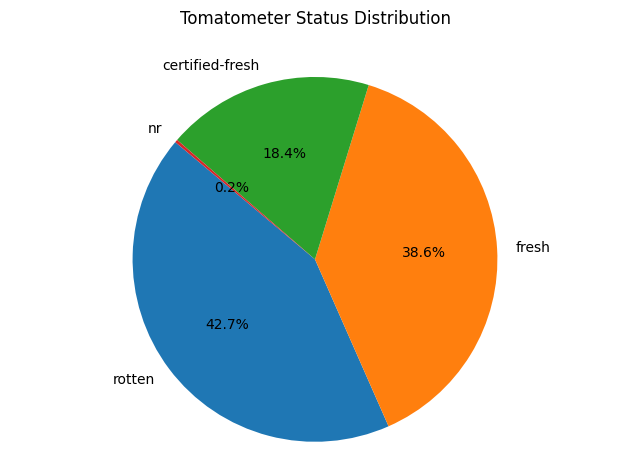

In [69]:
status_counts = raw_data['tomatometer_status'].value_counts()

plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140) 
plt.title('Tomatometer Status Distribution', pad=25)
plt.axis('equal')  
plt.tight_layout()  
plt.show()

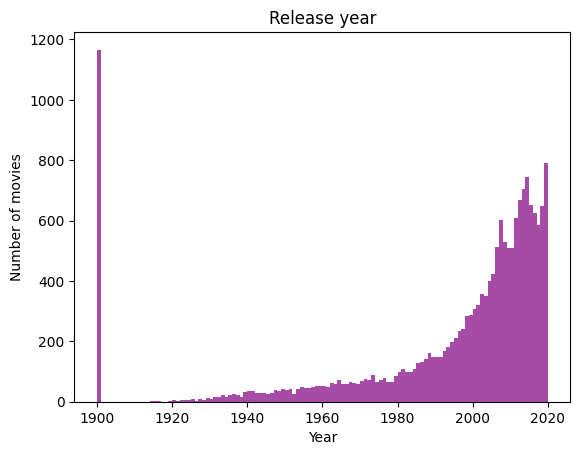

In [70]:
raw_data['release_year'] = pd.to_datetime(raw_data['original_release_date']).dt.year
plt.hist(raw_data['release_year'].dropna(), bins=range(raw_data['release_year'].min(), raw_data['release_year'].max() + 1), color='purple', alpha=0.7)
plt.title('Release year')
plt.xlabel('Year')
plt.ylabel('Number of movies')
plt.show()

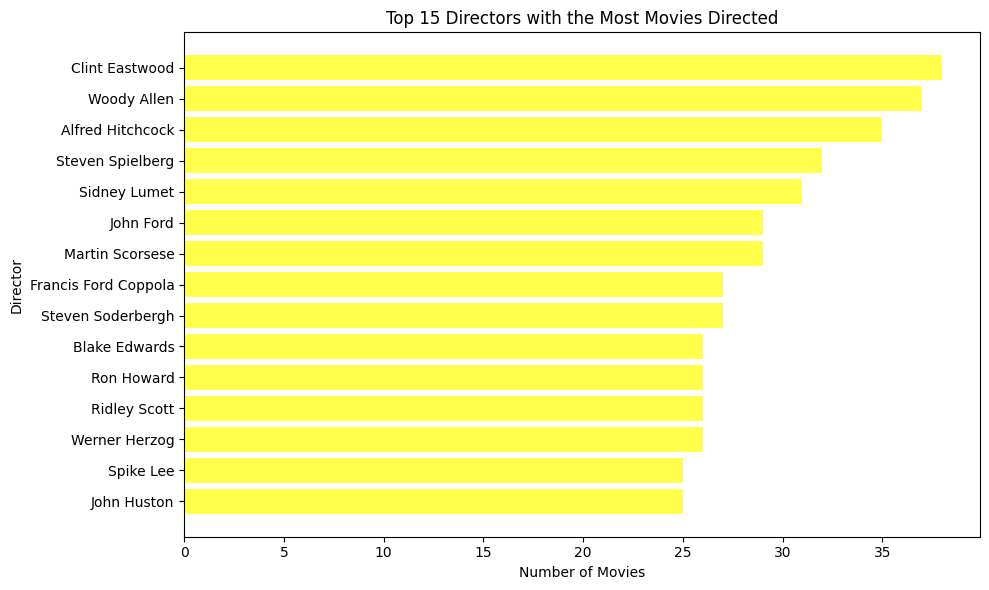

In [71]:
plt.figure(figsize=(10, 6))
plt.barh(top_directors.index, top_directors.values, color='yellow', alpha=0.7)
plt.xlabel('Number of Movies')
plt.ylabel('Director')
plt.title('Top 15 Directors with the Most Movies Directed')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()

In [72]:
# Filter rating = 100
number_movies = clean_data.shape[0]
rating_perfect = clean_data.query('tomatometer_rating == 100 & audience_rating == 100').shape[0]


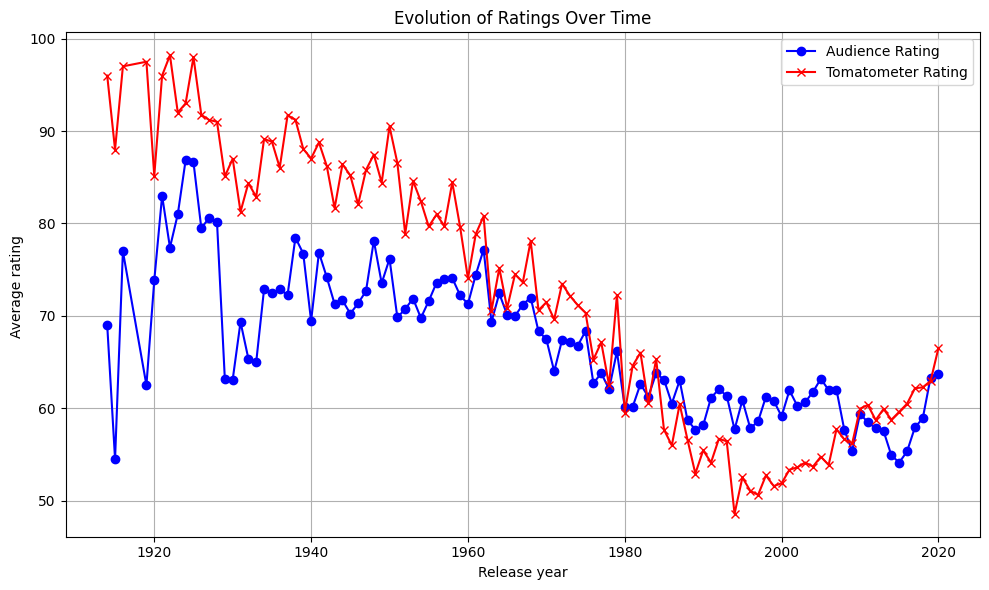

In [73]:
# Calculate average rating per year for audience
clean_data_filtered = clean_data[clean_data['release_year'] > 1900]
audience_rating_by_year = clean_data_filtered.groupby('release_year')['audience_rating'].mean()

# Calculate average rating per year for tomatometer
tomatometer_rating_by_year = clean_data_filtered.groupby('release_year')['tomatometer_rating'].mean()

# Graph the evolution of public ratings
plt.figure(figsize=(10, 6))
plt.plot(audience_rating_by_year.index, audience_rating_by_year.values, label='Audience Rating', color='blue', marker='o')
plt.plot(tomatometer_rating_by_year.index, tomatometer_rating_by_year.values, label='Tomatometer Rating', color='red', marker='x')

plt.title('Evolution of Ratings Over Time')
plt.xlabel('Release year')
plt.ylabel('Average rating ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [74]:

def __deepnote_big_number__():
    import json
    import jinja2

    from jinja2 import meta
    from sql_utils_helpers import get_variable_value

    def render_template(template):
        parsed_content = jinja2.Environment().parse(template)

        required_variables = meta.find_undeclared_variables(parsed_content)

        context = {
            variable_name: get_variable_value(variable_name)
            for variable_name in required_variables
        }

        result = jinja2.Environment().from_string(template).render(context)

        return result

    rendered_title = render_template("Number of movies")
    rendered_comparison_title = render_template("Rating 100/100")

    return json.dumps({
        "comparisonTitle": rendered_comparison_title,
        "comparisonValue": f"{rating_perfect}",
        "title": rendered_title,
        "value": f"{number_movies}"
    })

__deepnote_big_number__()


'{"comparisonTitle": "Rating 100/100", "comparisonValue": "77", "title": "Number of movies", "value": "17709"}'

## Conclusion

We can see that the most common genres are drama, comedy, and action, while the highest-rated by the audience are Anime, Manga, and Documentary. Most audience ratings range between 75 and 85 points, with the majority of movies classified as Rotten. Film production has increased over time, although some movies from the year 1900 don't have a valid release year, which could be adjusted in the charts. The most prolific directors include Clint Eastwood, Woody Allen, Alfred Hitchcock, and Steven Spielberg. Although ratings declined between 1940 and 2000, they have improved in recent years. Of the 17,709 movies analyzed, 77 achieved a perfect score of 100 from both the audience and critics.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9fedf1da-d519-4e3a-9f03-5cc227c7f4f5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>